# 0. Initial set up
In this report, we will walk you through our learning process. At the same time, we will also include information about steps to run our code and visualize our results. 

First, please run the following code: 

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# I. Background
We used data made public for educational purposes by Yelp Inc.. To motivate students and researchers in their pursuits of developments of better algorithms and practices in tackling big and complex data, Yelp created public challenges by publishing a part of their data and  challeng scholars and curious minds to find meanings in their wealth of data. The data we downloaded from Yelp is 4.98GB; we used data from round 9 challenge. The link to the data is: https://www.yelp.com/dataset_challenge


## 1. Item-based recommendation system
## 2. Our original recommendation method
Our original recommendation system predicts businesses a user x will like based on x's based reviews. First, we feed our algorithm a list of x's past business reviews in a csv file. Each business review includes a list of binary attributes which indicates whether the business is in certain categories. For instance. McDonald might have a list of attributes such as "fastFood", "shopping" and "spa", so it will have a 1 for "fastFood" indicating it is a fast food resteurant and have 0 for both "shopping" and "spa". Each business also has a binary attribute "like" showing whether x likes the business or not. It is also the target attribute of our model. Yelp users can rate businesses from 1 to 5, with 5 being the best rating. We set a threshold of 4, so if x gives a 4 or 5 stars to a business, we say x likes it, so set the "like" attribute for the business to be 1, otherwise set it to be 0. 

Given a list of business reviews by x, we split the list into trainData and testData. We use the trainData to train on Decision Tree, Logistic Regression and Naive Bayes models. We then test each model's accuracy with our testData and write them to a file. Along the process we also calculate each model's precision score and recall score for comparison 
purpose later. Each user will be recorded as one row in the accuracy and precision_recall file and the format of accuracy file will be :

userID	               Decision Tree	Logistic Regression	 Naive Bayes
x	                    54.7309833	    56.95732839	         43.41372913
y                   	62.06206206	    66.36636637        	 38.23823824
...

The format of precision_recall file will be:

username	           DT_precision	DT_recall	LR_precision	LR_recall	NB_precision	NB_recall
x                    	0.375586854	0.418848168	0.262910798	   0.427480916	0.887323944	    0.40212766
y                    	0.396969697	0.421221865	0.260606061	   0.483146067	0.857575758	    0.331770223
...

After computing accuracy and precision_recall scores, we choose the model with the highest accuracy and use it to recommendate businesses. For instance, given the input to be a list of potential businesses and the model to be decision tree, we feed all the potential businesses to decision tree model and only output the ones the user x likes("like" attribute is predicted to be 1). Each potential business also has a list of binary attributes as business reviews discussed above, but it does not have "like" attribute since we are predicting user preferences. At the end our system will generate a file containing all the businesses user x likes out of the potential businesses. The file will look like:

McDonald
Slices
Frank
...


## 3. Testing the results
# IV. Results
# V. Evaluation

# II. Aims
First, we want to do some data exploration to find interesting patterns from the data. Some interesting questions that we wanted to answer are:
1, What are the times in a week where most people would check in to businesses on Yelp?
2, How does the distribution of users' number of reviews look like?
3, How does the distribution of users' ratings look like? 
4, What constitute businesses on Yelp?
5, Are there any correlations between Yelp users' number of friends and their average ratings?

Second, we decided to apply what we learned in this data science course to  create a system that recommends businesses to Yelp users. In particular, given that Yelp users may have reviewed businesses that they have experienced, we used the machine learning methods introduced in class to find out -- from a poll of potential businesses close to where the users are -- the businesses that they may like, and recommend those to the users. Our recommendation system has restrictions, which will be discussed later in our report.

In order to evaluate our models, we also implemented a tradition recommendation method: Item- Based recommendation Algorithm. We did analysis to measure how much our models' recommendations results differ from the Item-Based alogrithm's results. We also analyzed the predictive power of our model and Item-Based model -- given our data-- by the conventional training-testing approach. 

# III. Methods
## 1, Set up input data for models
### 1.1, Obtain and organize data:
- First, you have to download the Yelp data from https://www.yelp.com/dataset_challenge/dataset. You will find a compressed file in your Downloads forlder. Uncompress it (tar xvzf yelp_dataset_challenge_round9.tar), name it 'yelp_data', and move the resulting folder in the directory of this project (It has to be in the same directory as the source folder, i.e. not inside the source folder).

- Second, install dependency for this project: 
        pip install psycopg2 
        pip install simplejson

- Third, create the Yelp data based from the json files downloaded from Yelp. Into your terminal, inside this project folder: 
        createdb yelp
  cd into source folder, on your terminal: 
        psql yelp -f create_yelp_dataset.sql
  The schema of this data base are all written inside create_yelp_dataset.sql. We made some modifications to the general structure of data base given from Yelp DUY CAN YOU WRITE THIS PART
  Into the terminal: 
      python populate_db.py
  We do not make the code live in this report (functions inside populate_db are care called from this report), because this code should be run once only, and you should not make a mistake of running it again. The time it takes to import data from json files to local database is 40 mins- 60 mins. 
  
- (Optional) If you prefer to deal with .csv files, you can convert the json files to csv files
        
        python json_to_csv_converter.py json_file_name
   This actually does not help in anything in our project, except wasting your time. 

### 1.2, Set up input files
Our implementation requires reading and writing to files to communicate between differnt processes of the algorithms. 
First, create necessary folders:

In [ ]:
# Set up all necessary directories
import setup_io
setup_io.create_output_folders()

Inside our project folder, we created:
- ./output : Where all outputs are stored
- ./output/users: We need to find users' id that have reviewed a certain number of businesses in order to run our recommendation system. All these users ids will be quieried and ordered in order of descending users' number of reviews. The ids' are then written into files inside this folder
- ./output/original: Our algorithm requires that given an user's id, we have to extract information about attributes of all busnissess that the user experienced, and whether the user rated this business positively or negatively. Each user's data will split into training data and test data. All files used to run our original system will be stored inside this folder. Details of each file are explained later.
- ./output/item_based: Item- based recommendation algorithm requires inputs of user_id, businesses_id and users' ratings of the busineeses. We also divide each user's data into train data file and test data file. All files necessary to run this algorithm are stored inside this folder. Details of each file will be explained later.
- ./output/potentials: For each user, we queried businesses' id in the same cities as the businesses that the user has reviewed. These businesses are potential recommendations for the users. The two recommendation systems will predict -- from this pool of potential recommendations -- the businesses that the user will more likely to love. Data of potential recommendations, and cities that the users have been to, are all stored inside this folder. Files details will be explained later.

### 1.3, Find user_id of users who we want to run the recommendation system on
As we explained above, our model will take data of previous ratings of a particular user, and then learn from those data to decide whether that user will like any other restaurants. The more data we have about an users' previous opinions about businesses, the better we can learn about that user's preferences. Our model may not work for users who have not made any reviews of businesses before. Therefore, before we apply our model, we have to find out lists of users who have reviewed a significant number of businesses. We querried users and ordered them by descending number of reviews. We offer functions to select user_ids in 2 ways: 
- We select users who has reviewed more than a certain number of times. Call the following piece of code:

In [ ]:
import get_ideal_users as users
import macros as m
# Get user id that have more than a certain threshold number of reviews
threshold = 1000
fname = m.get_user_more_thres_fname(threshold)
users.get_more_threshold_users(threshold, fname)

There are only 9 users who have reviewed more than 1000 businesses. 
The above function will write all validate user_ids into file './output/users/users_more_<theshold>.txt'. Each user_id is in its own line.
- We can also select a specified number of users in order of descending number of reviews. Call: 

In [ ]:
import get_ideal_users as users
import macros as m
num_users = 100 # We get 100 user_id with the highest number of reviews
fname = m.get_user_limit_fname(num_users) # get the file name to store ideal user_id
users.get_users_limit(num_users, fname) # Get the 100 people with highest number of reviews

In [ ]:
import get_ideal_users as users
import macros as m
import get_reviews_attributes as process_input
# Get the first x users that have the most reviews
#num_users = 100 # Write your desired number of users to run analysis here, default is 100
fname = '../output/users/trial.txt'#m.get_user_more_thres_fname(1000)#m.get_user_limit_fname(num_users)
#users.get_users_limit(num_users, fname)
#training percent: 70
process_input.process_all_user_input(fname, 70, \
                                    m.default_star_threshold)

### 1.4, Find restaurants attributes
Given an user_id, we have to find attributes of restaurants that the users reviewed.
- We querried all attributes (what kind of parking lot?, free wifi?, etc.) and categories (Chinese food?, Italian food?, nail spa?, etc.) of restaurants that the user went to.  These attributes are stored in arrays of variable length inside the database, some elements of the array are arrays themselves, some aren't. We wrote raw data into file ./output/original/businesses_<userID>.txt . 
- From this raw input file, we used string methods to turn raw data of businesss features into binary data. The resulting data is written into files ./output/original/att_cat_<userID>_train.txt and ./output/original/att_cat_<userID>_test.txt. In order to do this, we processed raw data file to extract real restaurant features (For example, 'Free Wifi: False' is a real feature, "priceRange: {'1: True', '2: False', '3: False'}", then 'priceRange_1' is included in the list of attributes). We collected a set of attributes of all businesses; all attributes are written in comma-separated format on the first line of the file. For each business, we wrote its features into binary format based on the set of all attributes that we collected earlier.
- The last attribute that we write into this file (./output/original/att_cat_<userID>_train/test.txt) is whether or not the user like the bus or not. To keep thing simple, we decided that if the user rated the restaurant more than 4 stars, the user like the business.

Code for this process of data cleaning is written in get_reviews_attributes.py.


To get the two files of train and test data for our original methods of using traditional machine learning methods, we can run the following: 

In [ ]:
import get_reviews_attributes as process_input
import macros as m
process_input.get_businesses('DK57YibC5ShBmqQl97CKog')
bus_ib_exclude = process_input.process_one_user_input('DK57YibC5ShBmqQl97CKog', 70, m.default_star_threshold)

In the code above, parameters include: 
(1) the id of the user that we want to create train and test data of businesses attributes that the user has been to
(2) The percentage of training data, out of all data . We always use 70% of our data for training and 30% for testing
(3) Star_threshold dictates how we decide whether an user like a business or not. We choose the default_star_threshold to be 4. Any businesses receiving ratings higher than this threshold are considered liked by the user.

# VI. Some visualization

In [ ]:
import restaurant_location_ratings
#restaurant_location_ratings.create_res_loc_ratings_by_city()
#restaurant_location_ratings.plot_res_loc_ratings_by_city()

## 1, Users' number of friends vs their ratings
We want to investigate whether there are any relationships between users' number of friends and their average ratings. To do this, we querried users' number of friends (length of friends array inside users table in the database), and their average ratings. We then created a scatter plot to demonstrate the potential relationship. Call the following piece of code: 

After executing the command to find users' number of friends and ratings


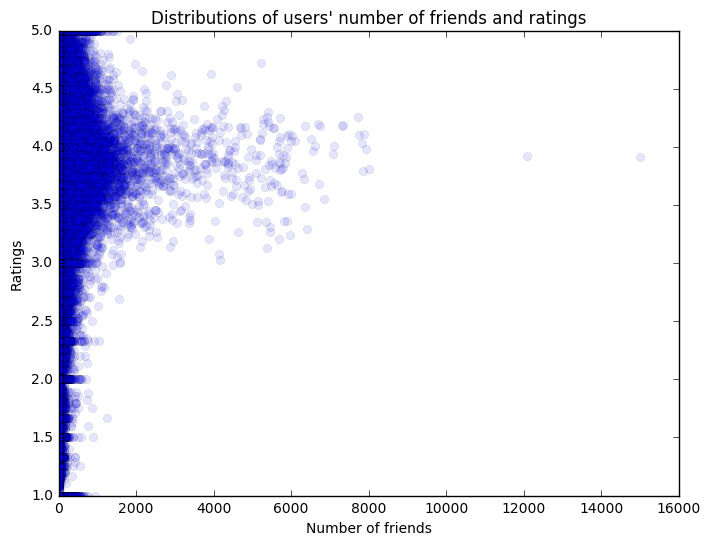

Done


In [1]:
import visualize_friends_stars_users as f_r
import matplotlib.pyplot as plt

friends, ratings = f_r.get_friends_ratings_friends()
plt.figure(figsize=(8, 6))
plt.plot(friends, ratings, 'o', alpha = 0.1)
plt.ylabel("Ratings")
plt.xlabel("Number of friends")
plt.title("Distributions of users' number of friends and ratings")
plt.show()
print "Done"

People who have the most number of friends also tend to rate businesses in the range 3.5-4.5, which is significantly high. Our hypothesis to explain this phenomenon is that users with more friends tend to be more sociable, hence they tend to go hang out with friends, which boost their moods and help them enjoy the atmosphere and services more, and they rate businesses significantly higher.

## 2, Popular check-ins time throughout the week
We wanted to investigate the time during the week when users check in most often in each city. In order to do this, we:
(1) Find cities with the most number of check-ins in all businesses existent in the cities. We hard coded our code so that we will only find the 10 cities with the most number of total check-ins. Function get_popular_time.py/ get_cities() will querry the database and find out these cities.
(2) For each city, we find the average number of check-in in each hours of the week per restaurant (total number of check-ins during an hour in a city / number of businesses in that city). This information is printed out into "../output/check_in_time_by_cities/<city_name>_check_ins.txt"
(3) After data of average check-ins/hour/restaurant in different cities, we generate plots to visualize such information for all cities. The plots are generated in "../output/check_in_time_by_cities/<city_name>_check_ins.png". These plots are not polished, each day in the week are colored differently, and the colors are not well aligned. Therefore, we created a representative plot using Tableu. This figure is stored inside 'plots_to_git/LasVegas_check_ins.png'.

We cannot shot these generated plots in this report, but they show intersting pattern that in each day of the week, there are two peaks time for check-ins, early morning and late at night. Interestingly, the number of check-ins per restaurants are generally lowest at noonish (11AM - 1PM).

In order to call functions to generate plots to find pupolar check-ins times at different cities (all data stored inside "../output/check_in_time_by_cities"), call: 

In [ ]:
# Code to create such files and plots to demonstrate the most popular check-in time during the week for\
# individual cities
import get_popular_time
# create a bunch of files that record the time adn average check-ins time for each city, but we only record\
# 10 cities with the most number of check-ins
get_popular_time.create_popular_time_cities()
get_popular_time.plot_popular_time_all_cities()

## 3, 

Done executing the command to find users' number of friends and ratings
[4.0, 2.0, 1.0, 3.0, 5.0]
[1032654L, 358550L, 540377L, 517369L, 1704200L]


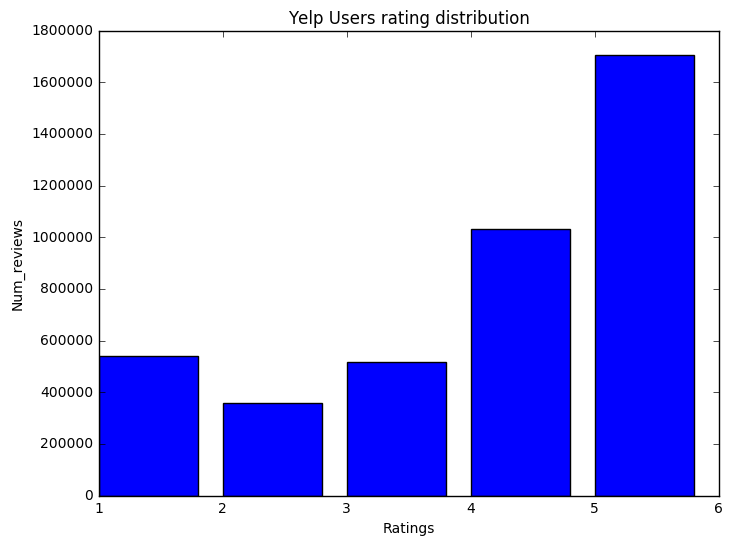

Done


In [6]:
import ratings_distribution as rd
import matplotlib.pyplot as plt
stars, num_stars = rd.get_star_distribution()
print stars
print num_stars
plt.figure(figsize=(8, 6))
plt.bar(stars, num_stars)
plt.ylabel("Num_reviews")
plt.xlabel("Ratings")
plt.title("Yelp Users rating distribution")
plt.show()
print "Done"